In [1]:
import numpy as np
import math
import os
from scipy import interpolate
from decimal import *
import string
import pickle
import pylab as P
from mpl_toolkits.axes_grid1 import make_axes_locatable, SubplotDivider, Size
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib
import scipy.ndimage as ndimage
import glob
import re
from matplotlib.widgets import Slider
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
C = 29979245800.0 # speed of light  (cm/s)
OMm = 0.31
OMl = 1.0 - OMm
hlittle = 0.68 # little hubble h
Ho = hlittle*3.2407e-18 # s^-1 at z=0

### what lines and redshift indexes

In [3]:
lines = np.array(['xH_nohalos', 'delta_T', 'SFRD', 'gas_mass', 'I_HI1216A', 'I_HI1216AdIGM',  'I_OII3726A', 'I_OIII5007A' ])
begin0 = np.array([18, 15, 12, 16,  17, 21,  18, 19   ])
begin1 = np.array([27, 24, 21, 25, 26, 30,  27, 28  ])
ends0 = np.array([32, 29, 26, 30, 31, 35,  32, 33 ])
ends1 = np.array([41, 38, 35, 39, 40, 44,  41, 42 ])
normaliz = np.array([1., 1., 1., 0.014, 1e-23, 1e-23, 1e-23, 1e-23   ])
plotname = np.array(["x_{\\rm HI}", "\\delta T_{\\rm b}\,{\\rm [mK]}", "\\log(\\dot \\rho_\\star / {\\rm M_\\odot\\,yr^{-1}\\,Mpc^{-3}})", "\\log (Z/Z_\\odot)", "\\log (I_{\\rm Ly\\alpha}^{\\rm SF} /{\\rm Jy\\, sr^{-1}})", 
                    "\\log (I_{\\rm Ly\\alpha}^{\\rm IGM} /{\\rm Jy\\, sr^{-1}})",  "\\log (I_{\\rm O\\,III} /{\\rm Jy\\, sr^{-1}})", "\\log (I_{\\rm O\\,III} /{\\rm Jy\\, sr^{-1}})"])
colormaps = np.array(['gist_yarg', 'seismic', 'afmhot', 'rainbow', 'viridis',  'viridis', 'viridis', 'viridis'])
flipbox = np.array(['1', '1', '1', '1', '1', '1', '1', '1', ])

In [4]:
# function DTDZ returns the value of dt/dz at the redshift parameter z.
def dtdz(z):
    x = np.sqrt( OMl/OMm ) * pow(1+z, -3.0/2.0)
    dxdz = np.sqrt( OMl/OMm ) * pow(1+z, -5.0/2.0) * (-3.0/2.0)
    const1 = 2 * np.sqrt( 1 + OMm/OMl ) / (3.0 * Ho)
    
    numer = dxdz * (1 + x*pow( pow(x,2) + 1, -0.5))
    denom = x + np.sqrt(pow(x,2) + 1)
    
    return (const1 * numer / denom)
# comoving distance (in cm) per unit redshift
def drdz(z):
    return (1.0+z)*C*dtdz(z)

In [5]:
# Generates the co-eval redshifts output by 21cmFAST/21CMMC.
# Set z_min, z_max and z_step_factor. These must be the same as in 21cmFAST/21CMMC.
ZLOW = 5.0 # ZLOW in Programs/drive_logZscroll_Ts.c
ZHIGH = 25. # Z_HEAT_MAX in Parameter_files/HEAR_PARAMS.H
z_step_factor = 1.02 # ZPRIME_STEP_FACTOR in Parameter_files/HEAT_PARAMS.H
z = ZLOW*1.0001

# Box size and resolution of the 21cm Boxes
BoxRes = '200' # Sould be STRING
BoxSize_Float = 500. # Sould be INTEGER
BoxSize = str(int(BoxSize_Float)) + 'Mpc'

Redshifts = []
Redshifts_float = []
count = 0
while z < ZHIGH:
    count = count + 1
    zp = str(round(z,6))
    Redshifts.append(zp)
    Redshifts_float.append(round(z,6))
    z = ((1.+z)*z_step_factor - 1.)
N_REDSHIFT = count
Redshifts_float = Redshifts_float[::-1]

# Generate redshifts corresponding to each pixel.
dR = (BoxSize_Float / float(BoxRes)) * 3.086e24 # size of cell (in comoving cm), 3.086e24 -> cm/Mpc.
z1_LC = Redshifts_float[N_REDSHIFT-1]
z_LC = start_z = z1_LC
i = 0
LightConeRedshifts = [] 
while z1_LC < Redshifts_float[0]:
    z2_LC = float(Redshifts_float[N_REDSHIFT-2-i])
    while z_LC < z2_LC: # until we move to the next set of boxes
        LightConeRedshifts.append(z_LC)
        z_LC -= dR / drdz(z_LC)
    z1_LC = z2_LC
    i += 1

In [6]:
FolderName = "./limfast-master/limfast_bt/Boxes/"

def findz(param,bg0,bg1,end0,end1):
    #print str(param)
    #print '%s%s__zstart*_zend*_FLIPBOXES1_%s_%s_lighttravel'%(FolderName,param,BoxRes,BoxSize)
    # Find the redshifts for the light-cone boxes. Specifying the start and end redshift of each component of the light-cone
    filename_full = glob.glob('%s%s__zstart*_zend*_FLIPBOXES%s_%s_%s_lighttravel'%(FolderName,param,flipbox[g],BoxRes,BoxSize))
    
    for i in range(len(filename_full)):
        filename = os.path.basename(filename_full[i])
        Redshifts_LightCone_Begin.append(str(filename[bg0:bg1]))
        Redshifts_LightCone_End.append(str(filename[end0:end1]))
    begin = Redshifts_LightCone_Begin.sort()
    end = Redshifts_LightCone_End.sort()
    
    # The total number of light-cone boxes
    Nboxes = len(Redshifts_LightCone_Begin)
    return Nboxes


def findzmetal(param,bg0,bg1,end0,end1, Redshifts_LightCone_Begin, Redshifts_LightCone_End):
    #print str(param)
    #print '%s%s__zstart*_zend*_FLIPBOXES1_%s_%s_lighttravel'%(FolderName,param,BoxRes,BoxSize)
    # Find the redshifts for the light-cone boxes. Specifying the start and end redshift of each component of the light-cone
    filename_full = glob.glob('%s%s__zstart*_zend*_FLIPBOXES%s_%s_%s_lighttravel'%(FolderName,param,flipbox[g],BoxRes,BoxSize))
    
    for i in range(len(filename_full)):
        filename = os.path.basename(filename_full[i])
        Redshifts_LightCone_Begin.append(str(filename[bg0:bg1]))
        Redshifts_LightCone_End.append(str(filename[end0:end1]))
    begin = Redshifts_LightCone_Begin.sort()
    end = Redshifts_LightCone_End.sort()
    
    # The total number of light-cone boxes
    Nboxes = len(Redshifts_LightCone_Begin)
    return Nboxes

In [7]:
# Define some matplotlib global variables
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('text',usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

# Define the colour map to be used to present the light-cone data
EoR_colour = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', [(0, 'white'),(0.33, 'yellow'),(0.5, 'orange'),(0.68, 'red'),(0.833, 'black'),(0.87, 'blue'),(1, 'cyan')])
plt.register_cmap(cmap=EoR_colour)


sub_adj_l = 0.06
sub_adj_b = 0.20
sub_adj_r = 0.92
sub_adj_t = 0.80
sub_adj_w = 0.05
sub_adj_h = 0.05

### main over the loop

In [8]:
def repeat():
    
    Redshifts_LightCone_Begin =[]
    Redshifts_LightCone_End = []
    NumBoxes = findzmetal('metal_mass', 18, 27, 32, 41,Redshifts_LightCone_Begin, Redshifts_LightCone_End )
    # Beginning and end redshifts for the figures. Nothing interesting happens beyond z = 25, so I cut it there.
    zmin = ZLOW
    zmax = 14.82 # Check the z range of the hightest lightcone box is enough to capture this range. 
               # if the box size is quite big (e.g. 1.5Gpc) and lightcone boxes generated with 'ZHIGH = 30', this quantity should be reduced.

    # Determine the corresponding z pixel index with the redshift maximum set above
    for jj in range(len(LightConeRedshifts)):
        if np.fabs(LightConeRedshifts[jj] - zmax) <= 0.01:
            Nmax = jj + 1

    # A randomly chosen number (between 0 and the pixel size of the 21cm boxes). Since we can only plot a slice, must pick a slice number
    FixedYPos_coord = int(BoxSize_Float/3) # I just set an half of box size. One can set any pixel number.

    # Numpy arrays to hold the light-cone slice data
    LightConeBox = np.zeros((int(BoxRes),Nmax))
    LightConeBox_interp = np.zeros((int(BoxRes),Nmax))
    # Numpy arrays for splined quantities
    SplinedFunction = np.zeros(Nmax)
    SplinedFunction_Tb_Fiducial = np.zeros(Nmax)

    # Numpy arrays for the redshift/frequency axes of the figure
    LightConeRedshifts_ForFigure = np.zeros(Nmax)
    Frequencies_ForFigure = np.zeros(Nmax)

    # Numpy arrays for the x and y axis
    Y_Vals = np.zeros(int(BoxRes))
    X_Vals = np.zeros(Nmax)

    # Box width for the y-axis
    for ii in range(int(BoxRes)):
        Y_Vals[ii] = (0. + BoxSize_Float*(float(ii) + 0.)/((int(BoxRes)-1)))
        
    for k in range(NumBoxes):

        # Create the file string
        BoxNames = "%s%s__zstart%s_zend%s_FLIPBOXES%s_%s_%s_lighttravel"%(DataLocation,'metal_mass',Redshifts_LightCone_Begin[k],Redshifts_LightCone_End[k],'1',BoxRes,BoxSize)

        # Read in the 21cm brightness temperature data from file
        f = open("%s"%(BoxNames),'rb')
        IndividualLightConeBox = np.fromfile(f, dtype = np.dtype('float32'), count = int(BoxRes)*int(BoxRes)*int(BoxRes))    
        f.close()

        #print('check:', IndividualLightConeBox.shape)

        # Take out the randomly determined slice and store the full light-cone slice
        #print BoxRes
        #print BoxRes
        #print Nmax

        for ii in range(0,int(BoxRes)):
            for kk in range(0,int(BoxRes)):
                if ii+int(BoxRes)*k < Nmax:
                    LightConeBox[kk][ii+int(BoxRes)*k] = IndividualLightConeBox[ii + int(BoxRes)*( FixedYPos_coord + int(BoxRes)*kk )]

    return LightConeBox


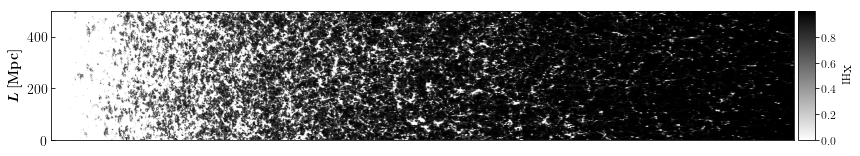

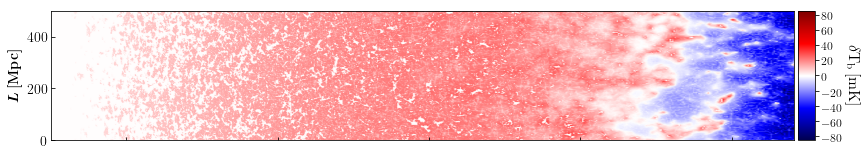

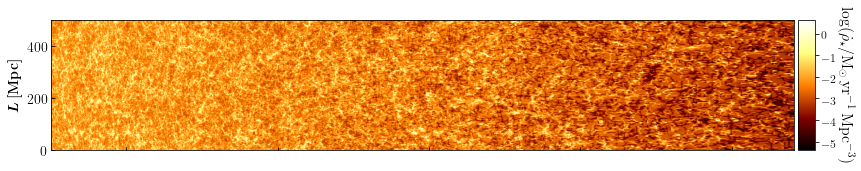

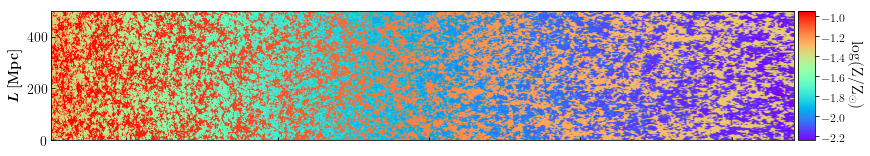

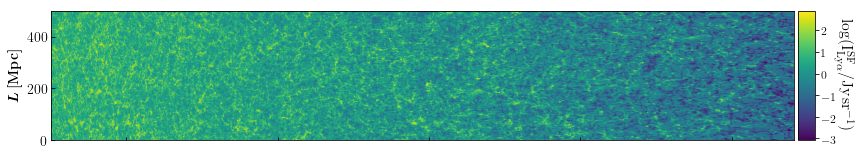

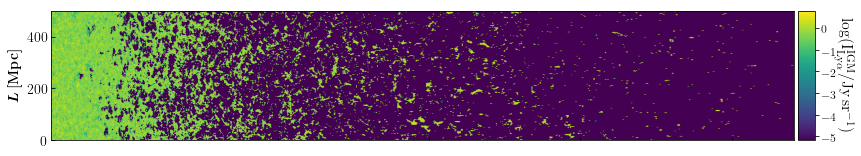

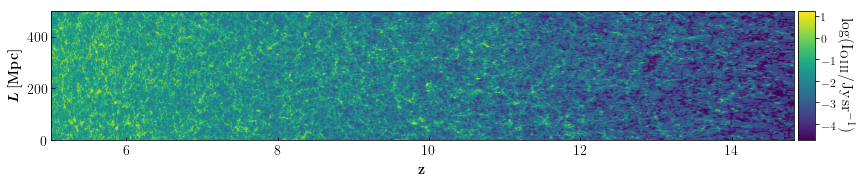

In [10]:
for g in range(len(lines[:-1])):

    Redshifts_LightCone_Begin =[]
    Redshifts_LightCone_End = []
    NumBoxes = findz(lines[g], begin0[g],begin1[g],ends0[g],ends1[g])
    #print NumBoxes
    # Beginning and end redshifts for the figures. Nothing interesting happens beyond z = 25, so I cut it there.
    zmin = ZLOW
    zmax = 14.82 # Check the z range of the hightest lightcone box is enough to capture this range. 
               # if the box size is quite big (e.g. 1.5Gpc) and lightcone boxes generated with 'ZHIGH = 30', this quantity should be reduced.

    # Determine the corresponding z pixel index with the redshift maximum set above
    for jj in range(len(LightConeRedshifts)):
        if np.fabs(LightConeRedshifts[jj] - zmax) <= 0.01:
            Nmax = jj + 1

    # A randomly chosen number (between 0 and the pixel size of the 21cm boxes). Since we can only plot a slice, must pick a slice number
    FixedYPos_coord = int(BoxSize_Float/3) # I just set an half of box size. One can set any pixel number.

    # Numpy arrays to hold the light-cone slice data
    LightConeBox = np.zeros((int(BoxRes),Nmax))
    LightConeBox_interp = np.zeros((int(BoxRes),Nmax))
    # Numpy arrays for splined quantities
    SplinedFunction = np.zeros(Nmax)
    SplinedFunction_Tb_Fiducial = np.zeros(Nmax)

    # Numpy arrays for the redshift/frequency axes of the figure
    LightConeRedshifts_ForFigure = np.zeros(Nmax)
    Frequencies_ForFigure = np.zeros(Nmax)

    # Numpy arrays for the x and y axis
    Y_Vals = np.zeros(int(BoxRes))
    X_Vals = np.zeros(Nmax)

    # Box width for the y-axis
    for ii in range(int(BoxRes)):
        Y_Vals[ii] = (0. + BoxSize_Float*(float(ii) + 0.)/((int(BoxRes)-1)))
        

    # Calculating the x-axis quantities. Either redshift, frequency or pixel number
    for ii in range(Nmax):
        LightConeRedshifts_ForFigure[ii] = LightConeRedshifts[ii]
        Frequencies_ForFigure[ii] = ((2.99792*10**8)/(0.2112*(1. + LightConeRedshifts_ForFigure[ii])))/(10**6)
        X_Vals[ii] = ii
        
    DataLocation = "./limfast-master/limfast_bt/Boxes/"
    for k in range(NumBoxes):

        # Create the file string
        BoxNames = "%s%s__zstart%s_zend%s_FLIPBOXES%s_%s_%s_lighttravel"%(DataLocation,lines[g],Redshifts_LightCone_Begin[k],Redshifts_LightCone_End[k],flipbox[g],BoxRes,BoxSize)

        # Read in the 21cm brightness temperature data from file
        f = open("%s"%(BoxNames),'rb')
        IndividualLightConeBox = np.fromfile(f, dtype = np.dtype('float32'), count = int(BoxRes)*int(BoxRes)*int(BoxRes))    
        f.close()

        #print('check:', IndividualLightConeBox.shape)

        # Take out the randomly determined slice and store the full light-cone slice
        #print BoxRes
        #print BoxRes
        #print Nmax

        for ii in range(0,int(BoxRes)):
            for kk in range(0,int(BoxRes)):
                if ii+int(BoxRes)*k < Nmax:
                    LightConeBox[kk][ii+int(BoxRes)*k] = IndividualLightConeBox[ii + int(BoxRes)*( FixedYPos_coord + int(BoxRes)*kk )]


    
    
    if str(lines[g]) == 'gas_mass':
        metals = repeat()
        LightConeBox = metals / LightConeBox
        
    LightConeBox /= normaliz[g] 
    
    if str(lines[g])== 'I_HI1216AdIGM':
        LightConeBox[np.where(LightConeBox < 1e-7)] = 1e-7
    
    if g !=0 and g !=1 and g != 3:
        LightConeBox = np.log10(LightConeBox)
        min_val = np.max(LightConeBox)-6
    elif g ==3:
        LightConeBox = np.log10(LightConeBox)
        min_val= np.min(LightConeBox)
    else:
        min_val = np.min(LightConeBox)

    
    
    max_val = np.max(LightConeBox)
    if g ==1:
        max_val = - min_val
    
    fig, ax = plt.subplots(figsize=(12,3))

    plt.subplots_adjust(sub_adj_l,sub_adj_b,sub_adj_r,sub_adj_t,sub_adj_w,sub_adj_h)
    # Add the x and y labels
    ax.set_ylabel(r"$\boldsymbol{L\,{\rm [Mpc]}}$",fontsize='large',labelpad=5)
    #ax.set_xlabel(r"$\boldsymbol{{\rm Frequency\,[MHz]}}$",fontsize='large',labelpad=10)
    if g == len(lines)-2:
        ax.set_xlabel(r"$\boldsymbol{{\rm z}}$",fontsize='large',labelpad=5)
    ax.set_xlim([5.1, 14.5])
    ax.xaxis.set_label_position('bottom')
    #ax.set_xticks([])
    if g != len(lines)-2:
        ax.set_xticklabels([])
    ax.tick_params(axis='both', direction='in', which='both', labelsize=14)

    ax.axis([LightConeRedshifts_ForFigure[0],LightConeRedshifts_ForFigure[-1],Y_Vals[0],Y_Vals[-1]])

    # Plot the light-cone data
    CS = ax.pcolormesh(LightConeRedshifts_ForFigure,Y_Vals,LightConeBox, vmin=min_val, vmax=max_val, 
                       cmap=colormaps[g],shading='gouraud')

    # Create the colour bar, and normalise the colour bar to be between min_val and min_val
    #divider = make_axes_locatable(ax)
    #cax = divider.new_horizontal(size="1%", pad=0.2)
    #fig.add_axes(cax)
    cax = fig.add_axes([0.925, 0.20, 0.02, 0.60])

    m = plt.cm.ScalarMappable(cmap=colormaps[g])
    m.set_array(LightConeBox)
    m.set_clim(vmin=min_val, vmax=max_val)

    # Add the colour bar, and the label
    cbar = plt.colorbar(m, cax=cax, pad=0.2)
    
    
    cbar.set_label(r"$\mathrm{{{0}}}$".format(plotname[g]),rotation=270,labelpad=18,fontsize=16)

    # Place the labelling and ticks for the colour bar
    #cbar.set_ticks(numpy.arange(-150., 31., 30.))
    #cbar.set_ticks([-3, 0, 3])
    #cbar.set_ticklabels([r"$-150$",r"$-120$",r"$-90$",r"$-60$",r"$-30$",r"$0$",r"$30$"])
    #cbar.set_ticklabels([r"$-3$",r"$0$",r"$3$"])
    #cbar_yticks = cbar.ax.yaxis.get_ticklabels()

    cbar.ax.tick_params(axis='y', direction='out', pad=2)

    #ax2 = ax.twiny()
    #ax2.set_xlim([5.0, 22.0])
    #m_f2z = interpolate.interp1d(Frequencies_ForFigure, LightConeRedshifts_ForFigure)
    #ax2.set_xticks([sm_f2z(175.), sm_f2z(150.), sm_f2z(125.), sm_f2z(100.), sm_f2z(75.)])
    #ax2.set_xticklabels([r"$175$", r"$150$", r"$125$", r"$100$", r"$75$"])
    #ax2.tick_params(axis='both', direction='in', which='both', labelsize=14)
    #ax2.set_xlabel(r"$\boldsymbol{{\rm Frequency\,[MHz]}}$",fontsize='large',labelpad=5)

    #plt.tight_layout()
    plt.savefig('./lightcone_pdf.pdf', dpi=300)
    plt.show()
    